<a href="https://colab.research.google.com/github/gavinn212/Flow-Sleuth---Port-Independent-Protocol-Identification-from-Flow-Statistics/blob/main/Protocol_Identification_new_data_set.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print("Loading CICIDS2017 Network Traffic Data...")

files = [
    'Tuesday-WorkingHours.pcap_ISCX.csv',
    'Wednesday-workingHours.pcap_ISCX.csv',
    'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    'Friday-WorkingHours-Morning.pcap_ISCX.csv',
    'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
    'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv'
]

dfs = []
for file in files:
    try:
        print(f"Loading {file}...")
        temp_df = pd.read_csv(file)
        temp_df.columns = temp_df.columns.str.strip()
        dfs.append(temp_df)
        print(f"{len(temp_df):,} samples")
    except:
        print(f"File not found")

df = pd.concat(dfs, ignore_index=True)

print(f"\nTotal samples: {len(df):,}")

label_col = 'Label' if 'Label' in df.columns else ' Label'

df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

print(f"After cleaning: {len(df):,}")
print(f"\nLabel distribution:")
for label, count in df[label_col].value_counts().items():
    print(f"  {label}: {count:,}")

df_mapped = pd.DataFrame()

df_mapped['duration'] = df['Flow Duration']
df_mapped['total_bytes'] = df['Total Length of Fwd Packets'] + df['Total Length of Bwd Packets']
df_mapped['total_packets'] = df['Total Fwd Packets'] + df['Total Backward Packets']
df_mapped['avg_packet_size'] = df['Average Packet Size']
df_mapped['packet_rate'] = df['Flow Packets/s']
df_mapped['byte_rate'] = df['Flow Bytes/s']

df_mapped['dst_port'] = df['Destination Port']

df_mapped['protocol'] = df[label_col]

df_mapped = df_mapped.replace([np.inf, -np.inf], np.nan)
df_mapped = df_mapped.dropna()

df = df_mapped

print(f"✓ Feature mapping complete")
print(f"Final dataset: {len(df):,} samples")
print(f"Features: {list(df.columns[:-1])}")
print(f"\nProtocol distribution:")
print(df['protocol'].value_counts())

Loading CICIDS2017 Network Traffic Data...
Loading Tuesday-WorkingHours.pcap_ISCX.csv...
445,909 samples
Loading Wednesday-workingHours.pcap_ISCX.csv...
692,703 samples
Loading Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv...
170,366 samples
Loading Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv...
288,602 samples
Loading Friday-WorkingHours-Morning.pcap_ISCX.csv...
191,033 samples
Loading Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv...
225,745 samples
Loading Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
286,467 samples

Total samples: 2,300,825
After cleaning: 2,298,395

Label distribution:
  BENIGN: 1,741,839
  DoS Hulk: 230,124
  PortScan: 158,804
  DDoS: 128,025
  DoS GoldenEye: 10,293
  FTP-Patator: 7,935
  SSH-Patator: 5,897
  DoS slowloris: 5,796
  DoS Slowhttptest: 5,499
  Bot: 1,956
  Web Attack � Brute Force: 1,507
  Web Attack � XSS: 652
  Infiltration: 36
  Web Attack � Sql Injection: 21
  Heartbleed: 11
✓ Feature mapping complete
Final 

In [72]:
print("\nStep 2: Training port-based baseline classifier")

# Prepare data - only use dst_port as feature
X_port = df[['dst_port']].values
y = df['protocol']

# Label encoding
le_baseline = LabelEncoder()
y_encoded = le_baseline.fit_transform(y)

# Split training and test sets
X_train_port, X_test_port, y_train_port, y_test_port = train_test_split(
    X_port, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Train decision tree classifier (based on port number)
baseline_model = DecisionTreeClassifier(max_depth=20, random_state=42)
baseline_model.fit(X_train_port, y_train_port)

# Evaluate baseline performance
y_pred_port = baseline_model.predict(X_test_port)
baseline_accuracy = accuracy_score(y_test_port, y_pred_port)

print(f"\nBaseline training completed")
print(f"Features: Only using dst_port (destination port number)")
print(f"Baseline accuracy: {baseline_accuracy*100:.1f}%")

# Display some example predictions
print(f"\nExample predictions (port number -> protocol):")
sample_indices = np.random.choice(len(X_test_port), 5, replace=False)
for idx in sample_indices:
    port = int(X_test_port[idx][0])
    true_proto = le_baseline.inverse_transform([y_test_port[idx]])[0]
    pred_proto = le_baseline.inverse_transform([y_pred_port[idx]])[0]
    match = "Correct" if true_proto == pred_proto else "Incorrect"
    print(f"   Port {port:5d} -> True: {true_proto:4s}, Predicted: {pred_proto:4s} [{match}]")


Step 2: Training port-based baseline classifier

Baseline training completed
Features: Only using dst_port (destination port number)
Baseline accuracy: 81.6%

Example predictions (port number -> protocol):
   Port    53 -> True: BENIGN, Predicted: BENIGN [Correct]
   Port    80 -> True: DoS Slowhttptest, Predicted: DoS Hulk [Incorrect]
   Port   443 -> True: BENIGN, Predicted: BENIGN [Correct]
   Port    80 -> True: DDoS, Predicted: DoS Hulk [Incorrect]
   Port    80 -> True: BENIGN, Predicted: DoS Hulk [Incorrect]



Step 3: Loading data...
Using CICIDS2017 dataset: 2298395 samples

Step 4: Feature engineering...
Feature matrix: (2298395, 6)
Features used: ['duration', 'total_bytes', 'total_packets', 'avg_packet_size', 'packet_rate', 'byte_rate']
Protocol mapping:
   0 -> BENIGN
   1 -> Bot
   2 -> DDoS
   3 -> DoS GoldenEye
   4 -> DoS Hulk
   5 -> DoS Slowhttptest
   6 -> DoS slowloris
   7 -> FTP-Patator
   8 -> Heartbleed
   9 -> Infiltration
   10 -> PortScan
   11 -> SSH-Patator
   12 -> Web Attack � Brute Force
   13 -> Web Attack � Sql Injection
   14 -> Web Attack � XSS
Train set: (1838716, 6)
Test set: (459679, 6)
Training completed in 436.62s

Step 5: Evaluation...
RESULTS
Overall Accuracy: 97.22%

Detailed Classification Report:
                            precision    recall  f1-score   support

                    BENIGN      0.987     0.977     0.982    348368
                       Bot      0.000     0.000     0.000       391
                      DDoS      0.948     0.984     0.96

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


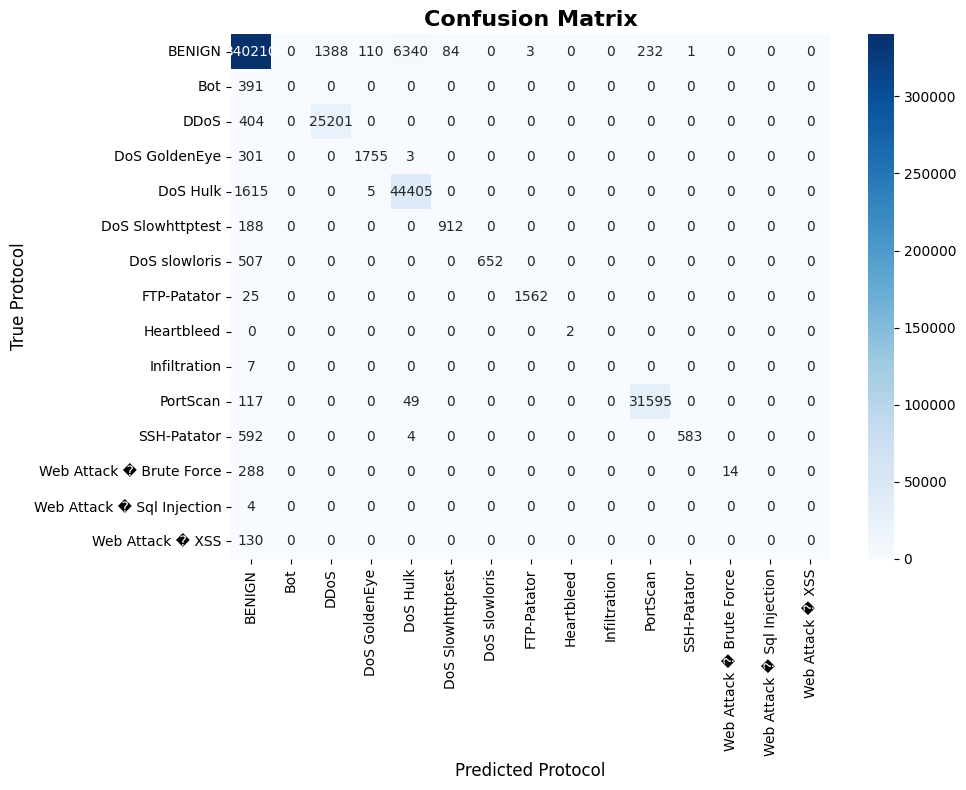

Confusion matrix saved

Feature Importance:
           feature  importance
1      total_bytes    0.313430
3  avg_packet_size    0.280560
4      packet_rate    0.119587
0         duration    0.101328
5        byte_rate    0.099846
2    total_packets    0.085249


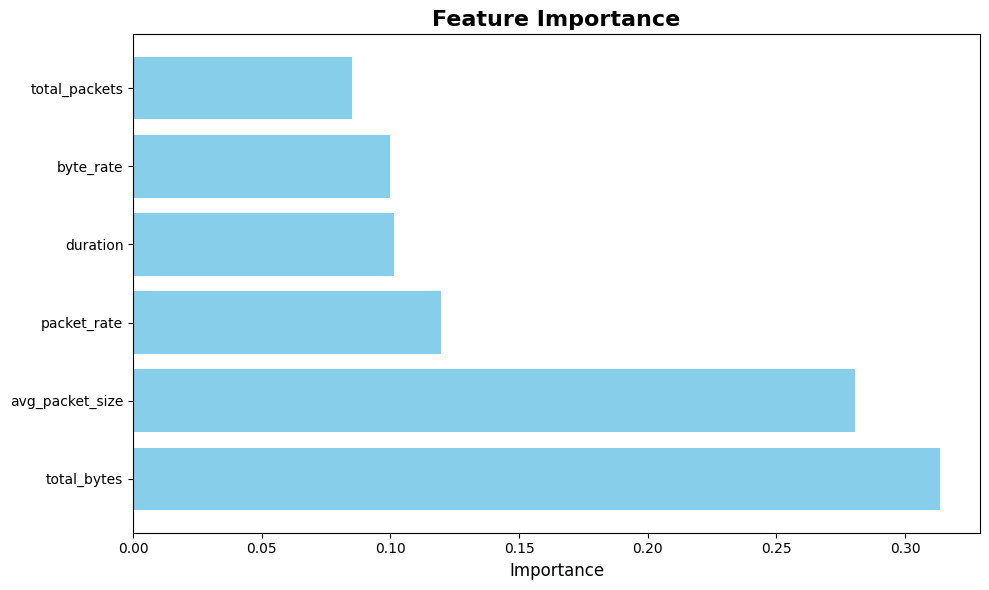

Feature importance saved


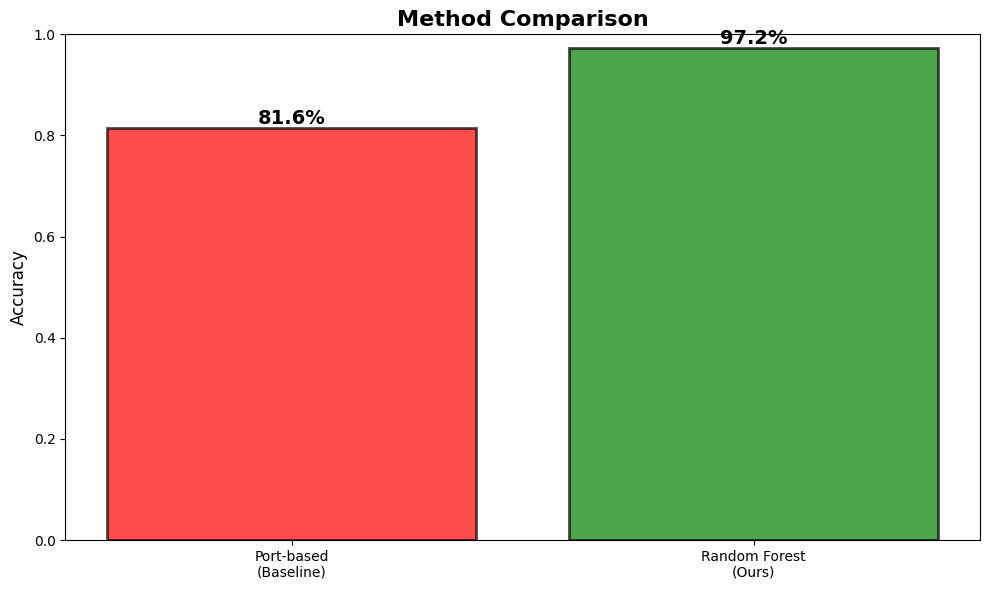

Method comparison saved
Final Results Summary

Method 1 - Port-based classifier:  81.6%
    Features: Only using dst_port (destination port number)
    Problem: Accuracy decreases when protocols use non-standard ports

Method 2 - Random Forest classifier:  97.2%
    Features: Using traffic statistics features (independent of port numbers)
    Advantage: Robust to changes in port numbers

Relative improvement:   19.2%


In [73]:
print("\nStep 3: Loading data...")
print(f"Using CICIDS2017 dataset: {len(df)} samples")

print("\nStep 4: Feature engineering...")

# Select features (excluding port numbers!)
feature_cols = [
    'duration',
    'total_bytes',
    'total_packets',
    'avg_packet_size',
    'packet_rate',
    'byte_rate'
]

X = df[feature_cols].fillna(0)
y = df['protocol']

print(f"Feature matrix: {X.shape}")
print(f"Features used: {feature_cols}")

# Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Protocol mapping:")
for i, protocol in enumerate(le.classes_):
    print(f"   {i} -> {protocol}")

# Data standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split training/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)
print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

import time
start = time.time()
model.fit(X_train, y_train)
train_time = time.time() - start

print(f"Training completed in {train_time:.2f}s")

print("\nStep 5: Evaluation...")

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"RESULTS")
print(f"Overall Accuracy: {accuracy*100:.2f}%\n")

print("Detailed Classification Report:")
print(classification_report(
    y_test, y_pred,
    target_names=le.classes_,
    digits=3
))

print("\nStep 6: Generating visualizations...")

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cmap='Blues'
)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Protocol', fontsize=12)
plt.xlabel('Predicted Protocol', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("Confusion matrix saved")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nFeature Importance:")
print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='skyblue')
plt.xlabel('Importance', fontsize=12)
plt.title('Feature Importance', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("Feature importance saved")

# Accuracy comparison chart
plt.figure(figsize=(10, 6))
methods = ['Port-based\n(Baseline)', 'Random Forest\n(Ours)']
accuracies = [baseline_accuracy, accuracy]

bars = plt.bar(methods, accuracies, color=['red', 'green'], alpha=0.7, edgecolor='black', linewidth=2)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Method Comparison', fontsize=16, fontweight='bold')
plt.ylim([0, 1])

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{accuracies[i]*100:.1f}%',
             ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('method_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Method comparison saved")

print("Final Results Summary")

print(f"\nMethod 1 - Port-based classifier:  {baseline_accuracy*100:.1f}%")
print(f"    Features: Only using dst_port (destination port number)")
print(f"    Problem: Accuracy decreases when protocols use non-standard ports")

print(f"\nMethod 2 - Random Forest classifier:  {accuracy*100:.1f}%")
print(f"    Features: Using traffic statistics features (independent of port numbers)")
print(f"    Advantage: Robust to changes in port numbers")

improvement = ((accuracy - baseline_accuracy) / baseline_accuracy) * 100
print(f"\nRelative improvement:   {improvement:.1f}%")

In [74]:
import pickle

model_package = {
    'model': model,
    'scaler': scaler,
    'label_encoder': le,
    'feature_names': feature_cols,
    'accuracy': accuracy
}

with open('protocol_detector.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("Model saved: protocol_detector.pkl")
print(f"Model accuracy: {accuracy*100:.2f}%")
print(f"Features: {feature_cols}")

Model saved: protocol_detector.pkl
Model accuracy: 97.22%
Features: ['duration', 'total_bytes', 'total_packets', 'avg_packet_size', 'packet_rate', 'byte_rate']


In [75]:
import pickle
import numpy as np
import pandas as pd

# Load model
with open('protocol_detector.pkl', 'rb') as f:
    model_package = pickle.load(f)

model = model_package['model']
scaler = model_package['scaler']
le = model_package['label_encoder']
feature_names = model_package['feature_names']

print("Model loaded successfully")
print(f"Model accuracy: {model_package['accuracy']*100:.2f}%")

# Test samples
test_samples = [
    # HTTP traffic characteristics
    {
        'duration': 5.0,
        'total_bytes': 50000,
        'total_packets': 80,
        'avg_packet_size': 800,
        'packet_rate': 15,
        'byte_rate': 8000
    },
    # P2P traffic characteristics
    {
        'duration': 120.0,
        'total_bytes': 5000000,
        'total_packets': 5000,
        'avg_packet_size': 1000,
        'packet_rate': 40,
        'byte_rate': 40000
    },
    # DNS traffic characteristics
    {
        'duration': 0.5,
        'total_bytes': 200,
        'total_packets': 2,
        'avg_packet_size': 100,
        'packet_rate': 4,
        'byte_rate': 400
    }
]

print("Testing model with sample data...")

for i, sample in enumerate(test_samples):
    # Extract features
    features = np.array([[sample[f] for f in feature_names]])

    # Standardize
    features_scaled = scaler.transform(features)

    # Predict
    pred = model.predict(features_scaled)[0]
    prob = model.predict_proba(features_scaled)[0]

    protocol = le.inverse_transform([pred])[0]
    confidence = prob[pred]

    print(f"\nSample {i+1}:")
    print(f"  Features: {sample}")
    print(f"  Predicted Protocol: {protocol}")
    print(f"  Confidence: {confidence*100:.2f}%")
    print(f"  All probabilities:")
    for j, p in enumerate(prob):
        print(f"    {le.classes_[j]}: {p*100:.2f}%")

print("Testing complete!")

Model loaded successfully
Model accuracy: 97.22%
Testing model with sample data...

Sample 1:
  Features: {'duration': 5.0, 'total_bytes': 50000, 'total_packets': 80, 'avg_packet_size': 800, 'packet_rate': 15, 'byte_rate': 8000}
  Predicted Protocol: BENIGN
  Confidence: 97.06%
  All probabilities:
    BENIGN: 97.06%
    Bot: 0.10%
    DDoS: 0.34%
    DoS GoldenEye: 0.07%
    DoS Hulk: 0.62%
    DoS Slowhttptest: 0.80%
    DoS slowloris: 1.00%
    FTP-Patator: 0.00%
    Heartbleed: 0.00%
    Infiltration: 0.00%
    PortScan: 0.00%
    SSH-Patator: 0.00%
    Web Attack � Brute Force: 0.01%
    Web Attack � Sql Injection: 0.00%
    Web Attack � XSS: 0.01%

Sample 2:
  Features: {'duration': 120.0, 'total_bytes': 5000000, 'total_packets': 5000, 'avg_packet_size': 1000, 'packet_rate': 40, 'byte_rate': 40000}
  Predicted Protocol: BENIGN
  Confidence: 95.45%
  All probabilities:
    BENIGN: 95.45%
    Bot: 1.36%
    DDoS: 0.01%
    DoS GoldenEye: 0.06%
    DoS Hulk: 0.12%
    DoS Slowhttpte

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Sample 3:
  Features: {'duration': 0.5, 'total_bytes': 200, 'total_packets': 2, 'avg_packet_size': 100, 'packet_rate': 4, 'byte_rate': 400}
  Predicted Protocol: BENIGN
  Confidence: 94.69%
  All probabilities:
    BENIGN: 94.69%
    Bot: 0.02%
    DDoS: 0.01%
    DoS GoldenEye: 0.02%
    DoS Hulk: 1.07%
    DoS Slowhttptest: 0.10%
    DoS slowloris: 1.04%
    FTP-Patator: 1.92%
    Heartbleed: 0.00%
    Infiltration: 0.00%
    PortScan: 0.00%
    SSH-Patator: 1.10%
    Web Attack � Brute Force: 0.01%
    Web Attack � Sql Injection: 0.00%
    Web Attack � XSS: 0.00%
Testing complete!


In [76]:
from google.colab import files

files.download('traffic_data.csv')
files.download('protocol_detector.pkl')
files.download('confusion_matrix.png')
files.download('feature_importance.png')
files.download('method_comparison.png')

print("All files downloaded!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All files downloaded!
